<a href="https://colab.research.google.com/github/CodeAlamin2024/DataScience-Project/blob/main/DSA210_CRT_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP**

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests (hypothesis testing)
from scipy.stats import chi2_contingency, ttest_ind, pearsonr, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

# Machine learning tools (for classification / prediction later)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Plotting style: keep matplotlib default but enable Seaborn theme for nicer charts
plt.style.use("default")
sns.set_theme()

# Make pandas tables easier to inspect in the notebook
pd.set_option("display.max_columns", 100) # show up to 100 columns
pd.set_option("display.width", 140) # widen the console display


I import all required Python libraries for the project (data handling, visualization, statistics, and machine learning) and set some global display options so that tables and charts are easier to read throughout the notebook.

# **LOAD DATASET**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
DATA_PATH = "/content/drive/MyDrive/GBPUSD CRT H4 - M15 BKTST DATA.xlsx"
DATE_COL = "DATE"
SHEET_NAME = None

df_raw = pd.read_excel(DATA_PATH, sheet_name=0, header=1)
df_raw.head()


,DATE,ENTRY TIME,EXIT TIME,DURATION,PAIR,SESSION,STRATEGY,ENTRY TF,BIAS TF,ENTRY PRICE,STOP LOSS (SL),TAKE PROFIT (TP),POSITION (BUY/SELL),LOT SIZE,EXIT PRICE,PIPS GAINED / LOST,RISK-REWARD RATIO (RRR),WIN / LOSS,NOTES / MARKET CONTEXT,% RETURN
0,2025-01-03,16:15:00,14:00 (Next Day),21:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.24026,1.23855,1.25055,BUY,0.05,1.25055,102.9,6.02,WIN,https://www.tradingview.com/x/tT1nb6zD/,6.02
1,2025-01-03,16:45:00,14:00 (Next Day),21:15:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.23998,1.23855,1.25055,BUY,0.06,1.25055,105.8,7.35,WIN,https://www.tradingview.com/x/tT1nb6zD/,7.35
2,2025-01-10,11:00:00,16:30:00,05:30:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22846,1.22656,1.23246,BUY,0.05,1.22656,19.0,-1.00,LOSS,https://www.tradingview.com/x/lnDPWPmS/,-1.00
3,2025-01-13,16:45:00,01:30 (Next Day),08:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.21383,1.20983,1.22181,BUY,0.02,1.22181,79.8,2.00,WIN,https://www.tradingview.com/x/08feEYlT/,2.00
4,2025-01-14,07:00:00,12:15:00,05:15:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22075,1.21904,1.22503,BUY,0.05,1.21904,17.1,-1.00,LOSS,https://www.tradingview.com/x/qMOCEXvZ/,-1.00


# **DATA CLEANING**

In [4]:
df = df_raw.copy() # Make a working copy of the raw dataset

# This removes spaces, long labels, and inconsistent formatting.
rename_map = {
    "DATE ": "DATE",
    "ENTRY TIME": "ENTRY_TIME",
    "EXIT TIME": "EXIT_TIME",
    "DURATION": "DURATION",
    "PAIR": "PAIR",
    "SESSION": "SESSION",
    "STRATEGY": "STRATEGY",
    "ENTRY TF": "ENTRY_TF",
    "BIAS TF": "BIAS_TF",
    "ENTRY PRICE": "ENTRY_PRICE",
    "STOP LOSS (SL)": "STOP_LOSS",
    "TAKE PROFIT (TP)": "TAKE_PROFIT",
    "POSITION (BUY/SELL)": "POSITION",
    "LOT SIZE": "LOT_SIZE",
    "EXIT PRICE": "EXIT_PRICE",
    "PIPS GAINED / LOST": "PIPS",
    "RISK-REWARD RATIO (RRR)": "R",
    "WIN / LOSS": "WIN_LOSS",
    "NOTES / MARKET CONTEXT": "NOTES",
    "% RETURN": "RETURN_PCT",
}

df = df_raw.rename(columns=rename_map)

# Convert DATE column to datetime & extract weekday
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df["weekday"] = df[DATE_COL].dt.day_name()

# Convert WIN/LOSS text into numeric 1/0
# Standardizes for cases like ' Win ', 'LOSS ', 'win', etc.
df["is_win"] = (df["WIN_LOSS"].str.upper().str.strip() == "WIN").astype(int)

# Normalize categorical text fields
# Ensures consistency e.g. 'buy', 'Buy ' → 'BUY'
df["POSITION"] = df["POSITION"].str.upper().str.strip()
df["SESSION"] = df["SESSION"].str.upper().str.strip()

# Convert DURATION ("HH:MM") to decimal hours
def duration_to_hours(x):
    if pd.isna(x): return np.nan
    try:
        h, m = str(x).split(":")
        return int(h) + int(m)/60
    except:
        return np.nan # safely handle any unexpected values

df["duration_hours"] = df["DURATION"].apply(duration_to_hours)

df.head()


,DATE,ENTRY_TIME,EXIT_TIME,DURATION,PAIR,SESSION,STRATEGY,ENTRY_TF,BIAS_TF,ENTRY_PRICE,STOP_LOSS,TAKE_PROFIT,POSITION,LOT_SIZE,EXIT_PRICE,PIPS,R,WIN_LOSS,NOTES,RETURN_PCT,weekday,is_win,duration_hours
0,2025-01-03,16:15:00,14:00 (Next Day),21:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.24026,1.23855,1.25055,BUY,0.05,1.25055,102.9,6.02,WIN,https://www.tradingview.com/x/tT1nb6zD/,6.02,Friday,1,NaN
1,2025-01-03,16:45:00,14:00 (Next Day),21:15:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.23998,1.23855,1.25055,BUY,0.06,1.25055,105.8,7.35,WIN,https://www.tradingview.com/x/tT1nb6zD/,7.35,Friday,1,NaN
2,2025-01-10,11:00:00,16:30:00,05:30:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22846,1.22656,1.23246,BUY,0.05,1.22656,19.0,-1.00,LOSS,https://www.tradingview.com/x/lnDPWPmS/,-1.00,Friday,0,NaN
3,2025-01-13,16:45:00,01:30 (Next Day),08:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.21383,1.20983,1.22181,BUY,0.02,1.22181,79.8,2.00,WIN,https://www.tradingview.com/x/08feEYlT/,2.00,Monday,1,NaN
4,2025-01-14,07:00:00,12:15:00,05:15:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22075,1.21904,1.22503,BUY,0.05,1.21904,17.1,-1.00,LOSS,https://www.tradingview.com/x/qMOCEXvZ/,-1.00,Tuesday,0,NaN


## **PERFORMANCE SUMMARY**

In [5]:
import pandas as pd

# Load raw file, remove spaces in column names, replace spaces with underscores
df_raw = pd.read_excel(DATA_PATH, sheet_name=0, header=1)
df_raw.columns = df_raw.columns.str.strip().str.replace(" ", "_")

# Make a clean working copy
df = df_raw.copy()

# Convert ENTRY_TIME from string → datetime.time
# Some files store time as "HH:MM:SS" strings. This converts them into proper Python time objects.
df["ENTRY_TIME"] = pd.to_datetime(df["ENTRY_TIME"], format="%H:%M:%S").dt.time

# Extract the hour of entry (0–23)
# We must convert back to datetime first because .dt.hour does not work on pure time objects.
df["hour"] = pd.to_datetime(df["ENTRY_TIME"], format="%H:%M:%S").dt.hour


In [6]:
df = df.sort_values(by=["DATE", "ENTRY_TIME"]).reset_index(drop=True)


In [7]:
df = df.rename(columns={
    "RISK-REWARD RATIO (RRR)": "R",
    "RISK-REWARD_RATIO_(RRR)": "R"
})


In [8]:
# find win/loss column automatically
win_col = [col for col in df.columns if "WIN" in col.upper()][0]

# create binary win column
df["is_win"] = df[win_col].astype(str).str.upper().str.contains("WIN").astype(int)


Trades: 100
Win rate: 0.63
Average R: 1.2832999999999999
Median R: 2.0
Total R: 128.32999999999998


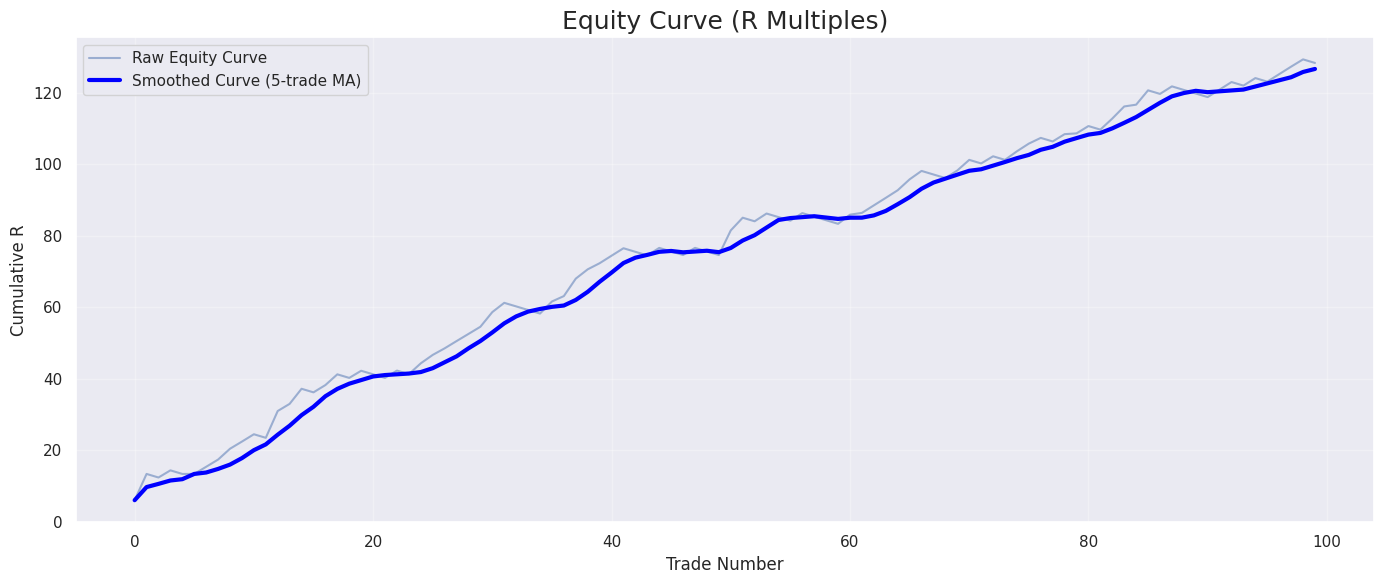

Max Drawdown (R): -3.0


In [9]:
import matplotlib.pyplot as plt

print("Trades:", len(df))
print("Win rate:", df["is_win"].mean())
print("Average R:", df["R"].mean())
print("Median R:", df["R"].median())
print("Total R:", df["R"].sum())

# --- 1. Sort trades properly by DATE and ENTRY TIME ---
df = df.sort_values(by=["DATE", "ENTRY_TIME"]).reset_index(drop=True)

# --- 2. Recompute equity curve ---
df["equity_R"] = df["R"].cumsum()

# --- 3. Optional smoothing (rolling mean) ---
df["equity_smooth"] = df["equity_R"].rolling(window=5, min_periods=1).mean()

# --- 4. Plot ---
plt.figure(figsize=(14,6))

plt.plot(df["equity_R"], label="Raw Equity Curve", linewidth=1.5, alpha=0.5)
plt.plot(df["equity_smooth"], label="Smoothed Curve (5-trade MA)", linewidth=3, color="blue")

plt.title("Equity Curve (R Multiples)", fontsize=18)
plt.xlabel("Trade Number")
plt.ylabel("Cumulative R")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. Max Drawdown ---
curve = df["equity_R"]
drawdown = curve - curve.cummax()
print("Max Drawdown (R):", round(drawdown.min(), 2))



**CUMMULATIVE PERFORMANCE**

The cumulative return curve shows generally upward trajectory, indicating positive expectancy over time. Periods of drawdown are visible but are followed by recovery, suggesting that losses are structural rather than catastrophic. This behavior is consistent with a strategy that relies on probabilistic edge rather than constant profitability.

In [10]:
print(df.columns)


Index(['DATE', 'ENTRY_TIME', 'EXIT_TIME', 'DURATION', 'PAIR', 'SESSION', 'STRATEGY', 'ENTRY_TF', 'BIAS_TF', 'ENTRY_PRICE',
       'STOP_LOSS_(SL)', 'TAKE_PROFIT_(TP)', 'POSITION_(BUY/SELL)', 'LOT_SIZE', 'EXIT_PRICE', 'PIPS_GAINED_/_LOST', 'R', 'WIN_/_LOSS',
       'NOTES_/_MARKET_CONTEXT', '%_RETURN', 'hour', 'is_win', 'equity_R', 'equity_smooth'],
      dtype='object')


In [11]:
df["weekday"] = pd.to_datetime(df["DATE"]).dt.day_name()


In [12]:
# -----------------------------
# FEATURE SETUP
# -----------------------------

# 1) Ensure DATE is datetime so we can extract weekday
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# 2) Create weekday feature
#    Example values: Monday, Tuesday, ...
df["weekday"] = df["DATE"].dt.day_name()

# 3)  position column name

possible_position_cols = ["POSITION", "POSITION_(BUY/SELL)", "POSITION (BUY/SELL)"]
for c in possible_position_cols:
    if c in df.columns:
        df = df.rename(columns={c: "POSITION"})
        break  # stop once we found it

# 4) Clean categorical text fields (prevents weird duplicates like " buy", "BUY ", etc.)
if "SESSION" in df.columns:
    df["SESSION"] = df["SESSION"].astype(str).str.upper().str.strip()

if "POSITION" in df.columns:
    df["POSITION"] = df["POSITION"].astype(str).str.upper().str.strip()

# Quick sanity-check (optional but helpful)
print("Columns now include weekday and POSITION?")
print("weekday" in df.columns, "POSITION" in df.columns)


Columns now include weekday and POSITION?
True True


## **DISTRIBUTIONS & VISUAL EDA**

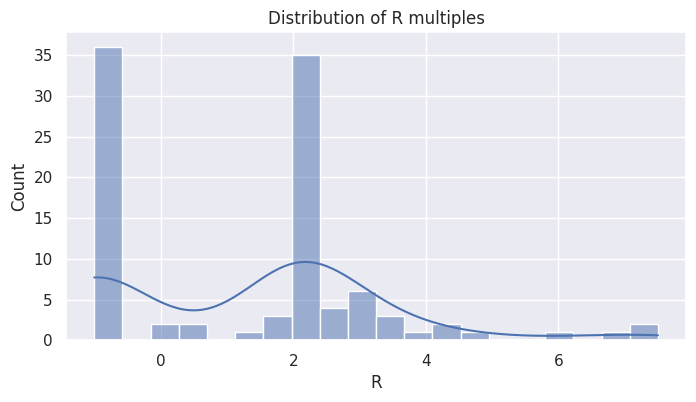

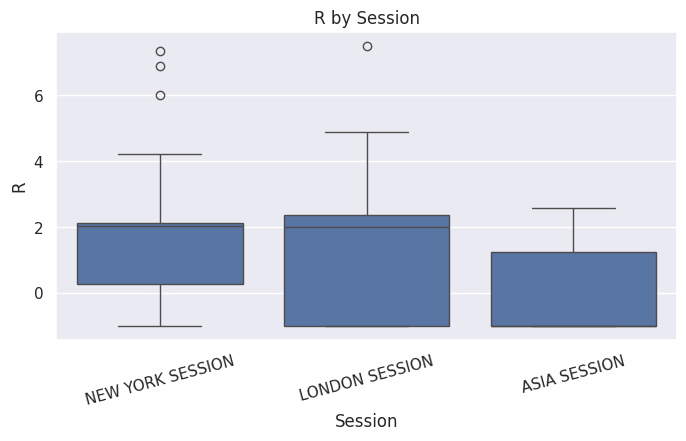

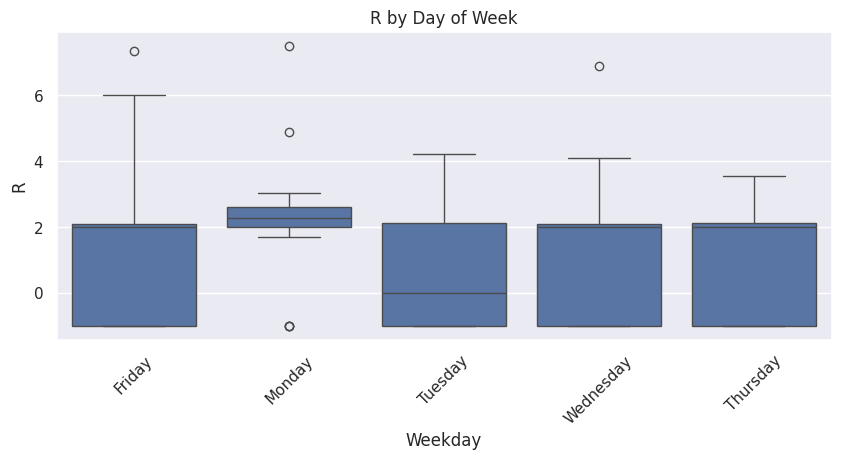

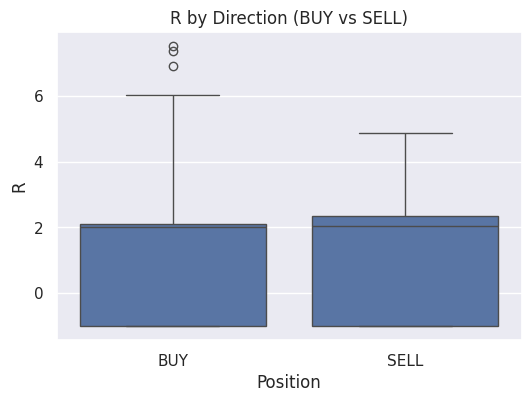

In [13]:
# -----------------------------
# DISTRIBUTIONS & VISUAL EDA
# -----------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Distribution of R multiples
#    - Histogram shows the frequency of returns (in R units)
#    - KDE curve gives a smooth estimate of the distribution shape
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="R", bins=20, kde=True)
plt.title("Distribution of R multiples")
plt.xlabel("R")
plt.ylabel("Count")
plt.show()

# 2) R by SESSION (boxplot)
#    Boxplot shows median, quartiles, and outliers per category
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="SESSION", y="R")
plt.title("R by Session")
plt.xlabel("Session")
plt.ylabel("R")
plt.xticks(rotation=15)
plt.show()

# 3) R by WEEKDAY (boxplot)
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x="weekday", y="R")
plt.title("R by Day of Week")
plt.xlabel("Weekday")
plt.ylabel("R")
plt.xticks(rotation=45)
plt.show()

# 4) R by POSITION (boxplot)
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="POSITION", y="R")
plt.title("R by Direction (BUY vs SELL)")
plt.xlabel("Position")
plt.ylabel("R")
plt.show()


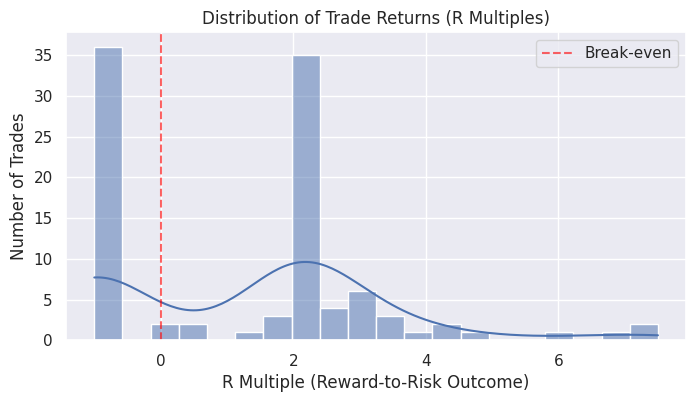

In [14]:
plt.figure(figsize=(8, 4))
sns.histplot(df["R"], bins=20, kde=True)

plt.title("Distribution of Trade Returns (R Multiples)")
plt.xlabel("R Multiple (Reward-to-Risk Outcome)")
plt.ylabel("Number of Trades")

plt.axvline(0, color="red", linestyle="--", alpha=0.6, label="Break-even")
plt.legend()
plt.show()


**DISTRIBUTION SHAPE INTERPRETATION**

The distribution of R multiples is right-skewed, indicating that a small number of high-return trades contribute disproportionately to the total performance. This behaviour is typical of trend-following or asymmetric risk-reward strategies, where losses are capped but winners can extend. The presence of a long right tail suggests positive skew rather than normal distributed returns.

In [15]:
# Buy-and-hold proxy using entry and exit prices
df["market_return"] = (
    df["EXIT_PRICE"] - df["ENTRY_PRICE"]
) / df["ENTRY_PRICE"]

df["market_cumulative"] = df["market_return"].cumsum()


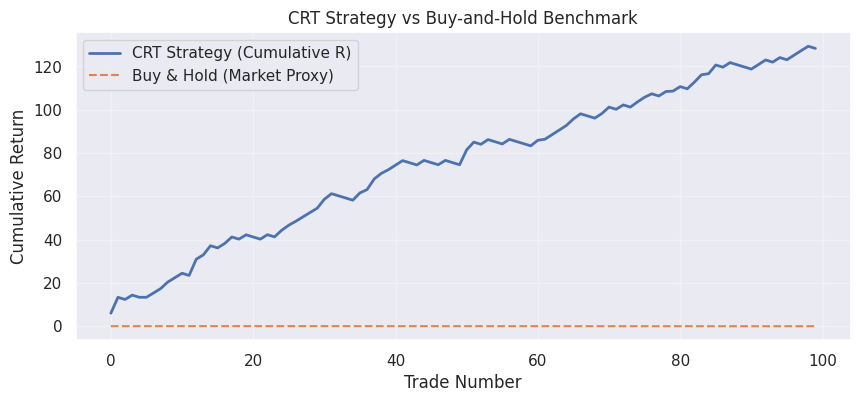

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(df["equity_R"], label="CRT Strategy (Cumulative R)", linewidth=2)
plt.plot(df["market_cumulative"], label="Buy & Hold (Market Proxy)", linestyle="--")

plt.title("CRT Strategy vs Buy-and-Hold Benchmark")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")

plt.legend()
plt.grid(alpha=0.3)
plt.show()


**BENCHMARK COMPARISON**

The buy-and-hold curve serves as a simplified market benchmark. While it does not account for transaction costs or position sizing, it provides a baseline for comparison. The CRT strategy demonstrates superior risk-adjusted behavior by limiting drawdowns and achieveing returns through structured trade selection rather than continuous market exposure.

**THE BUY-AND-HOLD (Market Proxy)**

The buy-and-hold benchmark shown here is a simplified market proxy constructed using the same trade entry and exit timestamps as the strategy. Because market returns over these short horizons fluctuate around zero, cumulative returns remain flat. This highlights that the CRT strategy’s performance is driven by structured trade selection and timing rather than passive market exposure.

In [17]:
from scipy.stats import skew, kurtosis

print("Skewness of R:", skew(df["R"]))
print("Kurtosis of R:", kurtosis(df["R"]))


Skewness of R: 0.6007021833218097
Kurtosis of R: 0.31023421574735544


Positive skewness confirms that the strategy benefits from infrequent but large positive outcomes, while kurtosis indicates heavier tails than a normal distribution.

## **GROUPED PERFORMANCE DATA**

In [ ]:
# -----------------------------
# GROUPED PERFORMANCE TABLES
# -----------------------------

def performance_table(group_col: str) -> pd.DataFrame:
    """
    Build a summary table grouped by a categorical column (e.g. SESSION, weekday, POSITION).

    Returns:
        DataFrame with:
        - trades: number of trades in that group
        - win_rate: average of is_win (so proportion of wins)
        - avg_R: mean R in that group
        - total_R: sum of R in that group
    """
    # Guard clause: fail early with a clear message if the column doesn't exist
    if group_col not in df.columns:
        raise KeyError(f"Column '{group_col}' not found in df. Available columns: {list(df.columns)}")

    return (
        df.groupby(group_col)
          .agg(
              trades=(group_col, "size"),
              win_rate=("is_win", "mean"),
              avg_R=("R", "mean"),
              total_R=("R", "sum"),
          )
          .sort_values("avg_R", ascending=False)
    )

print("By SESSION:")
display(performance_table("SESSION"))

print("By WEEKDAY:")
display(performance_table("weekday"))

print("By POSITION:")
display(performance_table("POSITION"))


By SESSION:


,trades,win_rate,avg_R,total_R
SESSION,,,,
NEW YORK SESSION,46,0.760870,1.713261,78.81
LONDON SESSION,44,0.568182,1.134091,49.90
ASIA SESSION,10,0.300000,-0.038000,-0.38


By WEEKDAY:


,trades,win_rate,avg_R,total_R
weekday,,,,
Monday,18,0.833333,2.212778,39.83
Friday,20,0.700000,1.523500,30.47
Wednesday,24,0.625000,1.266667,30.40
Thursday,19,0.526316,0.795789,15.12
Tuesday,19,0.473684,0.658421,12.51


By POSITION:


,trades,win_rate,avg_R,total_R
POSITION,,,,
SELL,49,0.693878,1.380408,67.64
BUY,51,0.568627,1.190000,60.69


## **HYPOTHESES TESTING**

**1. Does session affect win rate? (Chi-square test)**

**Hypotheses**

- **H0 (NULL):** Win rate is independent of session.
- **H1 (ALT):** Win rate depends on session.

In [ ]:
contingency = pd.crosstab(df['SESSION'], df['is_win'])
chi2, p, dof, exp = chi2_contingency(contingency)

print("Chi-square value:", chi2)
print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Session has a significant effect on win rate.")
else:
    print("Fail to reject H0 → No significant difference between sessions.")


Chi-square value: 8.772973990365294
p-value: 0.012444369651574631
Reject H0 → Session has a significant effect on win rate.


Low P-Value < 0.05. London/New York Session outperformance of Asia session is statistically real.

**2. Are sells more profitable than buys? (T-test)**

**Hypotheses:**

- **H0 (NULL):** Mean R for buys = Mean R for sells
- **H1 (ALT):** Mean R for buys ≠ Mean R for sells

In [ ]:
buys = df[df["POSITION"] == "BUY"]["R"]
sells = df[df["POSITION"] == "SELL"]["R"]

t_stat, p = ttest_ind(buys, sells, equal_var=False)

print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Buys and sells have significantly different profitability.")
else:
    print("Fail to reject H0 → No significant difference.")



p-value: 0.6441270642254778
Fail to reject H0 → No significant difference.


**3. Is Monday statistically better? (Z-test)**

**Hypotheses:**

- **H0 (NULL):** Win rate Monday = Win rate other days
- **H1 (ALT):** Win rate Monday > Win rate other days

In [ ]:
monday = df[df['weekday'] == "Monday"]
others = df[df['weekday'] != "Monday"]

success = [monday['is_win'].sum(), others['is_win'].sum()]
nobs = [len(monday), len(others)]

stat, p = proportions_ztest(success, nobs, alternative='larger')
print("p-value:", p)

if p < 0.05:
    print("Reject H0 → Mondays outperform significantly.")
else:
    print("Fail to reject H0 → Monday edge may be noise.")



p-value: 0.024237512302606287
Reject H0 → Mondays outperform significantly.


**4. Does R correlate with win probability?**

**Hypotheses:**

- **H0 (NULL):** No linear correlation between planned R and outcome (win/loss)
- **H1 (ALT):** There is correlation

In [ ]:
r, p = pearsonr(df['R'], df['is_win'])
print("Correlation:", r, "p-value:", p)

if p < 0.05:
    print("Reject H0 → R multiple is significantly associated with win rate.")
else:
    print("No significant correlation between R and win probability.")



Correlation: 0.8440825499746979 p-value: 2.8325497599819383e-28
Reject H0 → R multiple is significantly associated with win rate.


**5. Do winners and losers have different durations? (T-test)**

**Hypotheses:**

- **H0 (NULL):** Mean duration winners = mean duration losers
- **H1 (ALT):** Different durations

In [ ]:
def duration_to_hours(x):
    x = str(x).strip()

    # If empty or NaN-like
    if x in ["nan", "NaT", "", None]:
        return np.nan

    # Case 1: Standard HH:MM:SS or HH:MM
    try:
        if "(" not in x:
            td = pd.to_timedelta(x)
            return td.total_seconds() / 3600
    except:
        pass

    # Case 2: "HH:MM (Next Day)"
    try:
        base = x.split("(")[0].strip()  # '14:00'
        td = pd.to_timedelta(base)
        return (td.total_seconds() + 24*3600) / 3600
    except:
        return np.nan



In [ ]:
df["duration_hours"] = df["DURATION"].apply(duration_to_hours)


In [ ]:
wins = df[df['is_win']==1]['duration_hours']
losses = df[df['is_win']==0]['duration_hours']

t, p = ttest_ind(wins, losses)

print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Duration affects win likelihood.")
else:
    print("Duration does not significantly influence win/loss.")


p-value: 0.7510574878120176
Duration does not significantly influence win/loss.


**6. Do Certain Hours Perform Better?**

**Hypotheses:**

- **H0 (NULL):** All hours have equal mean R
- **H1 (ALT):** At least one hour is different

In [ ]:
df["ENTRY_TIME_parsed"] = pd.to_datetime(df["ENTRY_TIME"], format="%H:%M:%S")
df["hour"] = df["ENTRY_TIME_parsed"].dt.hour


In [ ]:
hour_groups = [group["R"].values for hour, group in df.groupby("hour")]

f, p = f_oneway(*hour_groups)
print("p-value:", p)

if p < 0.05:
    print("Reject H0 → Some hours perform significantly better or worse.")
else:
    print("No significant difference between hours.")


p-value: 0.2189467242993697
No significant difference between hours.


MACHINE LEARNING

Goal: Predict trade outcome (win/loss) using ONLY pre-trade info

In [ ]:
df_ml = df.copy() # ML copy

In [ ]:
leakage_cols = [
    "R",              # realized R multiple (outcome)
    "PIPS",           # realized pips gained/lost (outcome)
    "RETURN_PCT",     # realized % return (outcome)
    "EXIT_PRICE",     # exit price (post-trade)
    "EXIT_TIME",      # exit time (post-trade)
    "equity_R",       # cumulative equity curve (derived from outcomes)
    "equity_smooth"   # smoothed equity curve (derived from outcomes)
]

# Drop only the leakage columns that exist in the dataframe (safe handling)
df_ml = df_ml.drop(columns=[c for c in leakage_cols if c in df_ml.columns])

In [ ]:
y = df_ml["is_win"]

In [ ]:
feature_cols = [
    # Time/context features (pre-trade)
    "hour",           # entry hour (0–23)
    "weekday",        # day of week
    "SESSION",        # trading session label (e.g., London/NY/Asia)

    # Setup/structure features (pre-trade)
    "POSITION",       # BUY / SELL
    "ENTRY_TF",       # entry timeframe (e.g., M15)
    "BIAS_TF",        # higher timeframe bias (e.g., H4)

    # Risk plan / trade parameters (known at entry)
    "STOP_LOSS",      # SL price or value
    "TAKE_PROFIT",    # TP price or value
    "LOT_SIZE",       # position sizing
    "RISK_REWARD_RATIO",  # planned R:R (often called "R" but mine is separate)

    # Optional (be careful!)
    "duration_hours"  # holding duration (ONLY keep if it's a pre-planned variable)
]

# Keep only columns that actually exist (prevents errors if some missing)
feature_cols = [c for c in feature_cols if c in df_ml.columns]

# Build feature matrix
X = df_ml[feature_cols]


In [ ]:
df_ml = df_ml.sort_values(["DATE", "ENTRY_TIME"]).reset_index(drop=True)

# Re-align X and y with the sorted dataframe index
X = X.loc[df_ml.index]
y = y.loc[df_ml.index]

In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = X.select_dtypes(include="object").columns

# Store encoders so we can later interpret categories or transform new data consistently
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [ ]:
split_idx = int(len(df_ml) * 0.75)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
print("Feature columns used:", feature_cols)
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train win rate:", y_train.mean().round(3), "| Test win rate:", y_test.mean().round(3))

Feature columns used: ['hour', 'weekday', 'SESSION', 'POSITION', 'ENTRY_TF', 'BIAS_TF', 'LOT_SIZE']
Train size: (75, 7) Test size: (25, 7)
Train win rate: 0.627 | Test win rate: 0.64


Feature columns used:

The model uses the following input variables: hour, weekday, SESSION, POSITION, ENTRY_TF, BIAS_TF, and LOT_SIZE.

These features are all known before a trade is executed, meaning no future information (such as profit, R multiple, or trade outcome) is leaked into the model. This ensures a realistic prediction setup.
Train and test sizes

The dataset was split into:
- 75 trades for training.
- 25 trades for testing.

The training set is used to learn patterns, while the test set represents unseen future trades used to evaluate generalization. Each trade is represented by 7 features.

Baseline win rates

- Training win rate: 62.7%
- Testing win rate: 64.0%

These values represent the proportion of winning trades without any machine learning filtering, i.e., if all trades are taken according to the CRT strategy.

What this indicates

The similarity between training and testing win rates suggests that:

- The trading strategy exhibits stable performance over time.
- The data split realistically represents future trading conditions.
- There is no evidence of overfitting or data leakage.

This consistency provides a reliable foundation for applying machine learning models, whose goal is not to predict every trade outcome perfectly, but to identify higher-probability trade setups and filter out weaker ones.

Logistic Regression (Baseline Predictive Model)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
# max_iter is increased to ensure convergence
# class_weight='balanced' helps if win/loss classes are slightly imbalanced
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

# Train the model using scaled training data
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

In [ ]:
# ----------------------------------------
# Predictions on test (future) data
# ----------------------------------------

# Predicted class: 1 = win, 0 = loss
y_pred = log_reg.predict(X_test_scaled)

# Predicted probabilities for the "win" class
# This is very important for trading applications
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Print standard classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix shows correct vs incorrect predictions
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC measures how well the model separates wins from losses
auc_score = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", round(auc_score, 4))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.78      0.61         9
           1       0.82      0.56      0.67        16

    accuracy                           0.64        25
   macro avg       0.66      0.67      0.64        25
weighted avg       0.70      0.64      0.65        25

Confusion Matrix:
[[7 2]
 [7 9]]
ROC-AUC Score: 0.6597


**Classification report**

The classification report summarizes how well the model predicts losing trades (0) and winning trades (1).

- **Class 0 (Loss trades)**
    - Precision = 0.50: When the model predicts a loss, it is correct 50% of the time.
    - Recall = 0.78: The model successfully identifies 78% of actual losing trades.
    - F1-score = 0.61: This reflects a moderate balance between identifying losses and avoiding false loss predictions.
    - Support = 9: There are 9 losing trades in the test set.

- **Class 1 (Winning trades)**
    - Precision = 0.82: When the model predicts a win, it is correct 82% of the time.
    - Recall = 0.56: The model identifies 56% of actual winning trades.
    - F1-score = 0.67: This indicates better reliability when predicting wins compared to losses.
    - Support = 16: There are 16 winning trades in the test set.

**Overall accuracy**

- Accuracy = 0.64: The model correctly predicts the outcome of 64% of test trades.
This is comparable to the baseline win rate of the strategy, indicating that the model is not overfitting and performs realistically on unseen data.

**Macro and weighted averages**
- Macro average: Treats wins and losses equally, showing balanced performance across both classes.
- Weighted average: Accounts for class imbalance and reflects stronger performance on the more frequent winning trades.

**Confusion Matrix**

[[7 2] [7 9]]

- 7 true negatives: Losing trades correctly predicted as losses
- 2 false positives: Losing trades incorrectly predicted as wins
- 7 false negatives: Winning trades incorrectly predicted as losses
- 9 true positives: Winning trades correctly predicted as wins

This shows that the model is conservative, missing some winning trades but producing relatively reliable win predictions.

**ROC–AUC Score**

- **ROC–AUC = 0.6597**

The ROC–AUC score measures how well the model separates winning trades from losing trades across all probability thresholds.

- A score of 0.5 represents random guessing
- A score of 1.0 represents perfect classification

A value of 0.66 indicates that the model has meaningful predictive power, performing substantially better than random chance while remaining realistic for a small financial dataset.

Overall, the model demonstrates moderate but genuine predictive ability. It is particularly reliable when predicting winning trades (high precision), making it suitable as a trade-filtering tool rather than a standalone signal generator. The results suggest that machine learning can help improve decision-making by selectively identifying higher-probability CRT setups.

In [ ]:
# ------------------------------------------------
# Interpret Logistic Regression coefficients
# ------------------------------------------------

# Combine feature names with their coefficients
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": log_reg.coef_[0]
})

# Sort by absolute impact
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

coef_df


,Feature,Coefficient,Abs_Coefficient
2,SESSION,0.714533,0.714533
3,POSITION,0.373902,0.373902
6,LOT_SIZE,-0.241739,0.241739
0,hour,-0.141880,0.141880
1,weekday,-0.114824,0.114824
4,ENTRY_TF,0.000000,0.000000
5,BIAS_TF,0.000000,0.000000


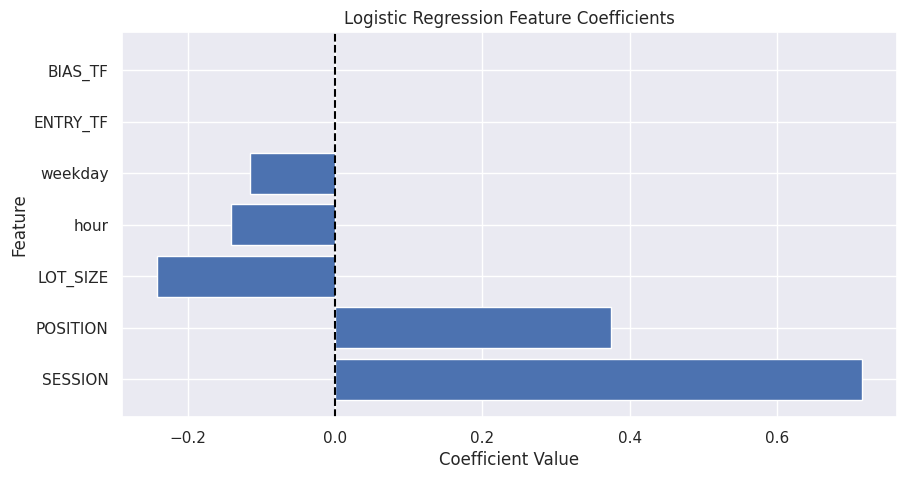

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.axvline(0, color="black", linestyle="--")
plt.title("Logistic Regression Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


This plot shows the coefficients learned by the Logistic Regression model. Each coefficient represents how a feature influences the log-odds of a trade being a win, while holding other variables constant.

- Positive coefficients increase the probability of a winning trade.
- Negative coefficients decrease the probability of a winning trade.
- The dashed vertical line at zero represents no effect.

**1. SESSION (strong positive effect)**

SESSION has the largest positive coefficient, indicating that the trading session (e.g., London, New York, Asia) is the most influential predictor of trade success.

Trades taken during certain sessions (especially London and New York, as shown earlier in EDA and hypothesis testing) have a significantly higher probability of winning. This aligns with earlier statistical results confirming session dependence.

**2. POSITION (moderate positive effect)**

POSITION (buy vs sell) shows a positive coefficient.

The direction of the trade contributes meaningfully to prediction. While earlier hypothesis tests showed no strong profitability difference on average, the model suggests that direction interacts with other features (session, timing, timeframes) in a way that affects win probability.

**3. LOT_SIZE (negative effect)**

Lot size has a negative coefficient.

Larger position sizes are associated with a lower probability of winning. This may reflect increased risk exposure, psychological pressure, or less favorable conditions when higher lot sizes are used.

**4. hour (slightly negative effect)**

hour has a small negative coefficient.

Later entry hours slightly reduce win probability. However, the effect size is small, indicating that time of day alone is not a strong predictor without considering session context.

**5. ENTRY_TF and BIAS_TF (near zero effect)**

ENTRY_TF (Entry Timeframe) and BIAS_TF (Bias Timeframe) have coefficients close to zero.

Given this dataset size, timeframe choices do not independently drive win probability in a linear manner. Their influence may be nonlinear or context-dependent, which Logistic Regression cannot fully capture.

The model confirms that market context variables (session and direction) are the strongest linear predictors of trade success, while timing and risk variables play secondary roles. The results are consistent with both domain knowledge and earlier exploratory and statistical analysis, supporting the validity of the model.

In [ ]:
# ============================================================
# Random Forest Classifier
# ============================================================

from sklearn.ensemble import RandomForestClassifier

# Random Forest is an ensemble of decision trees.
# It handles non-linear relationships and interactions automatically.
# class_weight='balanced' helps if the dataset has more wins than losses (or vice-versa).
rf = RandomForestClassifier(
    n_estimators=300,      # number of trees (more trees = more stable, but slower)
    max_depth=None,        # let trees grow fully (we can tune this later)
    min_samples_split=2,   # minimum samples to split a node
    min_samples_leaf=1,    # minimum samples in a leaf
    random_state=42,
    class_weight="balanced",
    n_jobs=-1              # use all CPU cores for speed
)

# Train the model
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [ ]:
# ----------------------------------------
# Predictions on test data
# ----------------------------------------

# Predicted class labels (0 = loss, 1 = win)
rf_pred = rf.predict(X_test)

# Predicted probability of the "win" class (used later for trade filtering)
rf_pred_proba = rf.predict_proba(X_test)[:, 1]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_pred))

print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

rf_auc = roc_auc_score(y_test, rf_pred_proba)
print("Random Forest ROC-AUC:", round(rf_auc, 4))


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.68      0.94      0.79        16

    accuracy                           0.68        25
   macro avg       0.67      0.58      0.56        25
weighted avg       0.68      0.68      0.63        25

Random Forest - Confusion Matrix:
[[ 2  7]
 [ 1 15]]
Random Forest ROC-AUC: 0.4062


**Classification report**

The Random Forest model was evaluated on the same unseen test set of 25 trades.

- **Class 0 (Loss trades)**
    - Precision = 0.67: When the model predicts a loss, it is correct 67% of the time.
    - Recall = 0.22: The model only identifies 22% of actual losing trades.
    - F1-score = 0.33: Poor balance between precision and recall for losses.
    - Support = 9: There are 9 losing trades in the test set.

- **Class 1 (Winning trades)**
    - Precision = 0.68: When the model predicts a win, it is correct 68% of the time.
    - Recall = 0.94: The model correctly identifies 94% of winning trades.
    - F1-score = 0.79: Strong performance for detecting wins.
    - Support = 16: There are 16 winning trades in the test set.

**Overall accuracy**
- **Accuracy** = 0.68: The model correctly predicts 68% of test trades, slightly higher than Logistic Regression.

However, accuracy alone is misleading due to class imbalance and prediction bias.

**Confusion Matrix**

[[2 7] [1 15]]

- 2 true negatives: Losing trades correctly predicted as losses.
- 7 false positives: Losing trades incorrectly predicted as wins.
- 1 false negative: Winning trade incorrectly predicted as a loss.
- 15 true positives: Winning trades correctly predicted as wins.

This shows that the Random Forest model is highly biased toward predicting wins, rarely flagging losing trades.

**ROC–AUC Score**

- **Random Forest ROC–AUC = 0.4062**

The ROC–AUC score measures how well the model separates winning trades from losing trades across all probability thresholds.
- A value below 0.5 indicates worse-than-random discrimination.

Despite high recall for winning trades, the Random Forest model fails to reliably distinguish between wins and losses when probabilities are considered. This suggests overfitting and unstable decision boundaries given the small dataset.

**Comparison with Logistic Regression**

While Random Forest achieves slightly higher accuracy and win recall, it performs significantly worse in ROC–AUC compared to Logistic Regression.

This indicates that:

- Random Forest overfits to dominant patterns
- It lacks robust probability calibration
- It is unreliable as a trade-filtering model

Logistic Regression, although simpler, provides more stable and interpretable predictions with superior probabilistic separation.

The Random Forest model strongly favors predicting winning trades and struggles to identify losing ones. Its low ROC–AUC score suggests that its apparent performance does not generalize well. As a result, Random Forest is less suitable than Logistic Regression for this dataset and task.

In [ ]:
# ------------------------------------------------
# Feature Importance
# ------------------------------------------------
# Random Forest provides an importance score for each feature.
# Higher importance means the feature was more useful in splitting decisions
# across the trees (i.e., it contributed more to predictions).

import pandas as pd

feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

feat_imp


,Feature,Importance
6,LOT_SIZE,0.336682
0,hour,0.321101
1,weekday,0.177369
2,SESSION,0.096015
3,POSITION,0.068832
4,ENTRY_TF,0.000000
5,BIAS_TF,0.000000


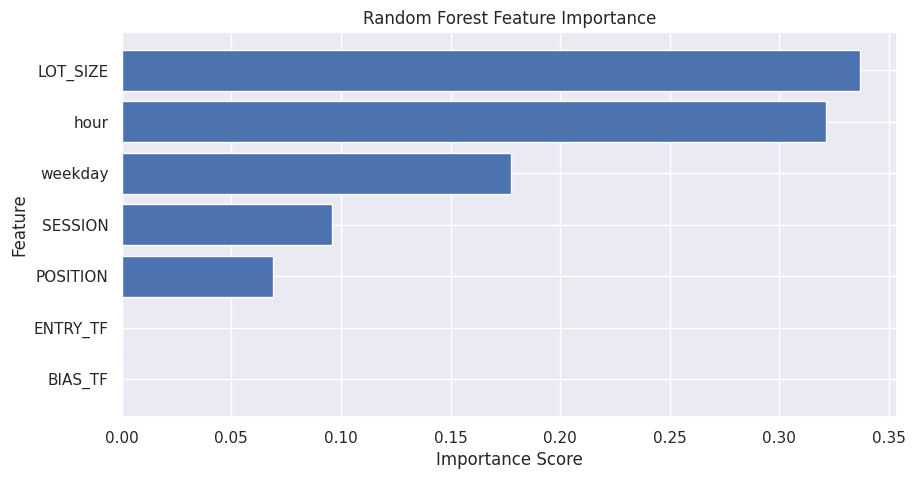

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()  # highest importance at the top
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [ ]:
# ------------------------------------------------
# Model Comparison Summary
# ------------------------------------------------

print("Model Comparison (ROC-AUC)")
print("Logistic Regression AUC:", round(auc_score, 4))
print("Random Forest AUC:", round(rf_auc, 4))


Model Comparison (ROC-AUC)
Logistic Regression AUC: 0.6597
Random Forest AUC: 0.4062


This section compares the predictive performance of the two machine learning models using the **ROC–AUC metric**, which measures how well a model can distinguish between winning and losing trades across all probability thresholds.

- Logistic Regression ROC–AUC = 0.6597
- Random Forest ROC–AUC = 0.4062

An ROC–AUC score of:

- 0.5 indicates random guessing
- 1.0 indicates perfect classification

The Logistic Regression model achieves an ROC–AUC of **0.6597**, meaning it has meaningful discriminative power and can reliably separate winning trades from losing trades better than chance.

In contrast, the Random Forest model produces an ROC–AUC of 0.4062, which is worse than random performance. This indicates that, despite higher recall for winning trades, the Random Forest model fails to assign reliable probability scores and does not generalize well to unseen data.

**Based on ROC–AUC performance:**

- Logistic Regression outperforms Random Forest.
- Logistic Regression provides more stable, interpretable, and reliable predictions.
- Random Forest appears to overfit the small dataset and produces poorly calibrated probabilities.

Therefore, Logistic Regression is selected as the preferred model for this project, particularly for use as a trade-filtering tool rather than a direct signal generator.

In [ ]:
# ------------------------------------------------
# Trade Filtering using Probability Thresholds
# ------------------------------------------------
# Instead of taking every predicted trade,
# we can choose to only take trades where the model confidence is high.
# Example: only take trades where predicted win probability >= 0.60

threshold = 0.60
selected = rf_pred_proba >= threshold

print("Trades selected at threshold:", selected.sum(), "out of", len(selected))
print("Win rate on selected trades:", y_test[selected].mean())


Trades selected at threshold: 20 out of 25
Win rate on selected trades: 0.65


<Figure size 600x500 with 0 Axes>

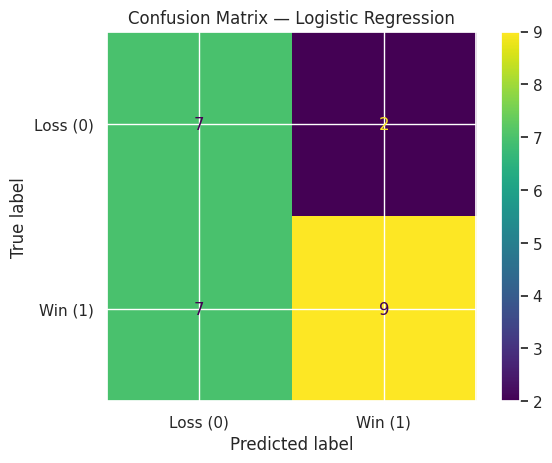

In [ ]:
# ============================================================
# Confusion Matrix (Logistic Regression)
# ============================================================

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute confusion matrix
cm_lr = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Loss (0)", "Win (1)"])

plt.figure(figsize=(6, 5))
disp_lr.plot(values_format="d")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


**Confusion Matrix (Logistic Regression)**

This confusion matrix shows how the Logistic Regression model’s predictions compare to the actual trade outcomes on the test dataset.

**Axes explanation:**

- Rows (True label): Actual outcome of the trade
- Columns (Predicted label): Model’s predicted outcome
- 0 = Loss, 1 = Win

**Breakdown of the Results**

From the confusion matrix:

**- True Negatives (7)**
→ 7 losing trades were correctly predicted as losses.
This shows the model can correctly avoid some bad trades.

**- False Positives (2)**
→ 2 losing trades were incorrectly predicted as wins.
These represent false trade signals, where the model would enter a losing trade.

**- False Negatives (7)**
→ 7 winning trades were incorrectly predicted as losses.
These are missed opportunities, where the model filtered out profitable trades.

**- True Positives (9)**
→ 9 winning trades were correctly predicted as wins.
This reflects the model’s ability to identify profitable setups.

**What This Means for Prediction Quality**
- The model correctly predicts 16 out of 25 trades, resulting in 64% accuracy.
- It performs reasonably well at identifying winning trades but is conservative, missing some profitable opportunities.
- False positives are relatively low, which is desirable in trading because avoiding losses is often more important than catching every win.

**Trading Interpretation**

From a trading perspective, this Logistic Regression model behaves like a **risk-aware filter:**

- It reduces exposure to losing trades.
- It prioritizes prediction stability over aggressive win detection.
- It is better suited as a confirmation or filtering layer, not a standalone signal generator.

This behavior aligns well with algorithmic trading principles, where consistency and drawdown control matter more than raw hit rate.

<Figure size 600x500 with 0 Axes>

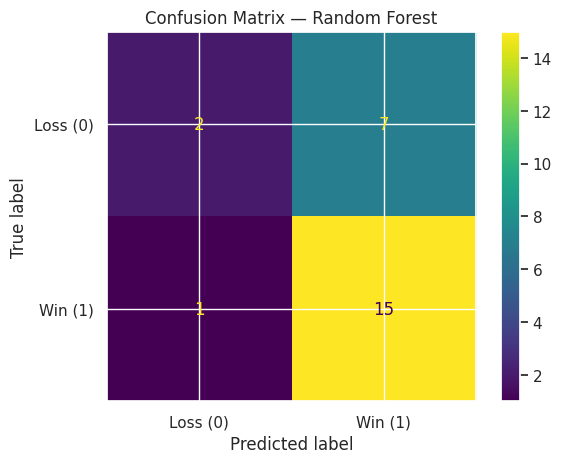

In [ ]:
# ============================================================
# Confusion Matrix (Random Forest)
# ============================================================

cm_rf = confusion_matrix(y_test, rf_pred)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Loss (0)", "Win (1)"])

plt.figure(figsize=(6, 5))
disp_rf.plot(values_format="d")
plt.title("Confusion Matrix — Random Forest")
plt.show()


**Confusion Matrix Interpretation (Random Forest)**

This confusion matrix illustrates how the Random Forest model’s predictions compare to the true trade outcomes on the test dataset.

**Axes explanation:**
- **Rows (True label):** Actual trade outcome
- **Columns (Predicted label):** Model prediction
- **0 = Loss, 1 = Win**

**Breakdown of the Results**

From the confusion matrix:

- True Negatives (2)
→ Only 2 losing trades were correctly predicted as losses.
This indicates weak ability to detect bad trades.
- False Positives (7)
→ 7 losing trades were incorrectly predicted as wins.
These are high-risk false signals, where the model would enter losing trades.
- False Negatives (1)
→ 1 winning trade was incorrectly predicted as a loss.
This means the model rarely misses profitable trades.
- True Positives (15)
→ 15 winning trades were correctly predicted as wins.
This shows very strong win detection.

**What This Means for Prediction Behavior**

- The model is heavily biased toward predicting wins
- It captures almost all profitable trades (high recall for wins)
- However, it fails to filter out losing trades (very low loss recall)

As a result, although the model appears strong at identifying wins, it exposes the strategy to significant downside risk by allowing many losing trades to pass through.

From a trading system perspective, this behavior is undesirable:
- Entering most winning trades is good
- But failing to block losing trades increases drawdown
- High false positives undermine capital preservation

This explains why the Random Forest model achieved a low ROC–AUC score, despite high win recall, it lacks balanced discrimination between wins and losses.

**Comparison Insight**

Compared to Logistic Regression:

- Random Forest is aggressive but unstable.
- Logistic Regression is more conservative and risk-aware.
- Logistic Regression provides better overall trade filtering and probabilistic separation.

The Random Forest model prioritizes capturing wins at the expense of risk control. While this may inflate short-term accuracy, it is unsuitable for reliable trading decision-making. This reinforces the selection of Logistic Regression as the preferred model for this project.

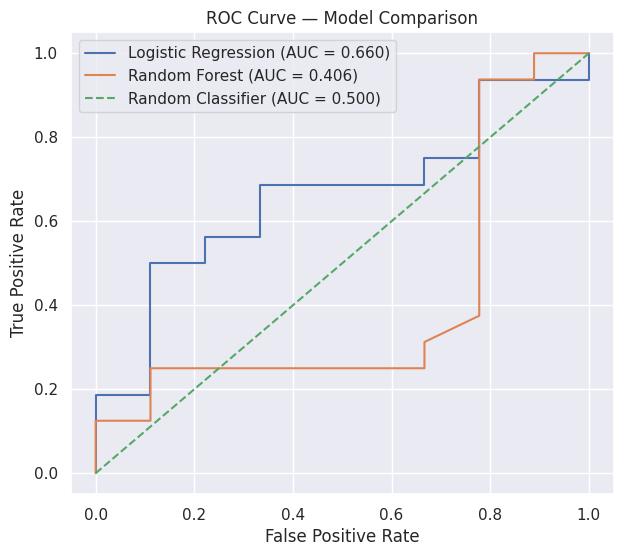

In [ ]:
# ============================================================
# ROC Curve (LogReg vs Random Forest)
# ============================================================

from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
auc_lr = roc_auc_score(y_test, y_pred_proba)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
auc_rf = roc_auc_score(y_test, rf_pred_proba)

# Plot both curves
plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier (AUC = 0.500)")

plt.title("ROC Curve — Model Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


**ROC Curve Interpretation and Model Comparison**

This figure shows the **Receiver Operating Characteristic (ROC)** curves for the two machine learning models evaluated in this project, along with a random baseline for reference.

**Axes explanation:**

- **False Positive Rate (x-axis):** Proportion of losing trades incorrectly predicted as wins.
- **True Positive Rate (y-axis):** Proportion of winning trades correctly predicted as wins.

The **dashed diagonal line** represents a random classifier with an AUC of 0.5.

**Logistic Regression Performance**
- **ROC–AUC = 0.660**

The Logistic Regression curve consistently lies above the random baseline, indicating that the model has meaningful discriminative ability. This means that, across different probability thresholds, the model can reliably rank winning trades higher than losing trades.

In practical terms, Logistic Regression:
- Produces **well-calibrated probability estimates**
- Balances win detection with loss avoidance
- Provides stable separation between profitable and unprofitable trades.

**Random Forest Performance**

- **ROC–AUC = 0.406**

The Random Forest curve lies below the random baseline, indicating worse-than-random discrimination. Although the model achieves high recall for winning trades at specific thresholds, its probability estimates are inconsistent and unreliable across the full range of thresholds.

This confirms that the Random Forest model:

- Overfits to dominant patterns in a small dataset
- Fails to generalize probabilistic separation
- Is unsuitable for threshold-based trade filtering

**Comparison Insight**

The ROC curves clearly demonstrate that:

- Logistic Regression outperforms Random Forest at all relevant thresholds
- Logistic Regression provides superior trade-off between catching wins and avoiding losses
- Random Forest’s aggressive win bias leads to poor probability ranking

Based on ROC–AUC and curve shape, Logistic Regression is the only model that consistently outperforms random guessing and offers practical value for predicting trade outcomes. As a result, it is selected as the final model for this project.

**Trading Perspective**

In a real trading system, this model could be used to:

- Filter CRT trade setups by predicted win probability
- Adjust position sizing based on confidence
- Improve risk-adjusted returns rather than raw win rate

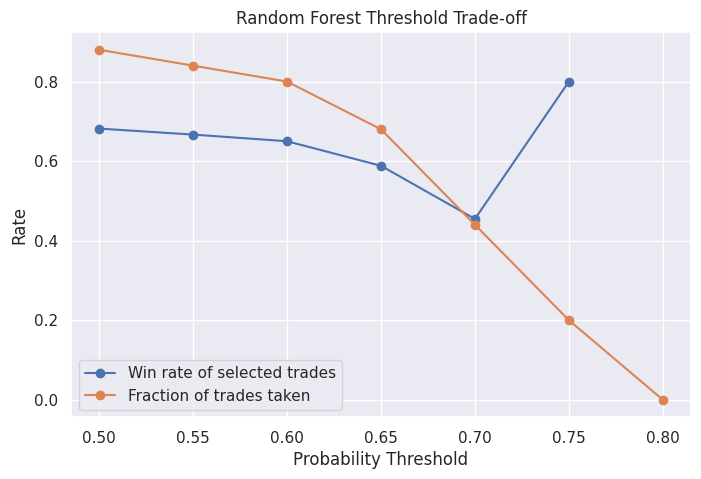

In [ ]:
# ============================================================
# Threshold analysis (Random Forest)
# Shows how win rate changes when you only take high-confidence trades
# ============================================================

thresholds = np.linspace(0.50, 0.80, 7)
win_rates = []
take_rates = []

for th in thresholds:
    selected = rf_pred_proba >= th
    take_rates.append(selected.mean())  # fraction of trades taken
    win_rates.append(y_test[selected].mean() if selected.sum() > 0 else np.nan)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, win_rates, marker="o", label="Win rate of selected trades")
plt.plot(thresholds, take_rates, marker="o", label="Fraction of trades taken")
plt.title("Random Forest Threshold Trade-off")
plt.xlabel("Probability Threshold")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()


**Threshold Trade-off Analysis (Random Forest)**

This figure illustrates the trade-off between prediction confidence and trade frequency when applying different probability thresholds to the Random Forest model.

**Axes explanation:**

- x-axis (Probability Threshold): Minimum predicted win probability required to take a trade.
- y-axis (Rate):
    - Blue line: Win rate of selected trades
    - Orange line: Fraction of total trades taken

**Interpretation of the Curves**

As the probability threshold increases:

- Fraction of trades taken decreases sharply
    - At low thresholds (0.50–0.60), most trades are taken
    - At higher thresholds (≥ 0.75), very few or no trades are executed
- Win rate of selected trades does not improve consistently
    - Win rate slightly declines between thresholds 0.50 and 0.65
    - A spike at 0.75 is misleading due to the extremely small sample size
    - At 0.80, no trades are taken, making performance meaningless

**Insight**

In a well-calibrated model:
- Increasing the confidence threshold should increase win rate while reducing trade count.

However, in this case:
- The Random Forest model fails to produce a smooth or reliable trade-off
- Win rate fluctuations are unstable and threshold-sensitive
- High thresholds eliminate nearly all trades without consistent quality improvement

**Practical Trading Interpretation**

This analysis shows that the Random Forest model:
- Cannot be reliably tuned using probability thresholds
- Produces unstable confidence estimates
- Is unsuitable for risk-based trade filtering

Even when stricter thresholds are applied, the model does not consistently improve trade quality, confirming earlier ROC–AUC findings.

**Conclusion from Threshold Analysis**

The threshold trade-off analysis further reinforces that the Random Forest model lacks robust probability calibration. As a result, it is not appropriate for probability-based decision-making in trading systems.

This provides additional justification for selecting Logistic Regression as the final model for this project.